In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsTransformer
from scipy.sparse.csgraph import csgraph_to_masked
from sklearn.metrics import adjusted_rand_score
from sknetwork.clustering import Louvain,get_modularity
from sknetwork.data import from_adjacency_list
import networkx as nx
from scanpy.neighbors._common import _get_indices_distances_from_sparse_matrix
from scanpy.neighbors._connectivity import umap
import anndata as ad
import scanpy as sc
import sys
sys.path.append('/home/bili/Lernen/ProjectsComBio')
from model.ricci_curv import ricciCurvature
%matplotlib inline

/home/bili/Apps/Mamba/envs/cb/lib/python3.11/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Sample from the grid
np.random.seed(0)
x = np.linspace(-1, 1, 2000)
f = lambda x: 0.5*(x**2 - 1)**2 + 1 
z = f(x)
points = x.copy()
dist = z.ravel()
norm_dist = (1/dist)/np.sum(1/dist)
sample_index = np.random.choice(points.shape[0], 1000, p=norm_dist)
sampled_points = points[sample_index]
point_height = f(sampled_points)
points_data = np.vstack((sampled_points,point_height)).T
knn_graph = KNeighborsTransformer(n_neighbors=30, mode='distance').fit_transform(points_data)
small_knn_graph = KNeighborsTransformer(n_neighbors=10, mode='distance').fit_transform(points_data)

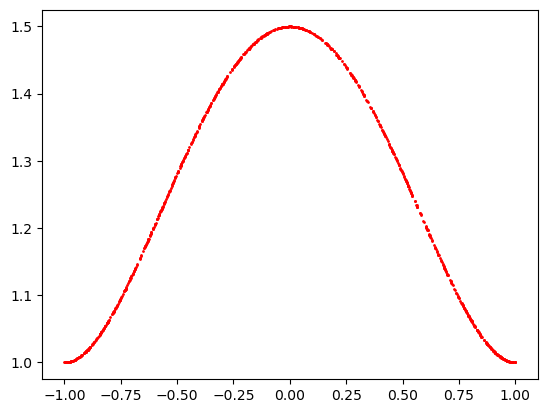

In [3]:
# Plot the samples and original function
fig = plt.figure()
ax = fig.add_subplot(111)
#plt.scatter(x, y, c='r', s=1)
ax.scatter(points_data[:,0],points_data[:,1], c='r', s=1)
# selective anchor points 
plt.show()

In [4]:
curvature = ricciCurvature(points_data,knn_graph)

In [5]:
# select indices on knn graph with the highest curvature
graph_mask = csgraph_to_masked(knn_graph)
curvature_masked = graph_mask * curvature
max_curv_indicies = np.argsort(np.abs(curvature_masked), axis=1)[:,:10]
min_curv_indicies = np.argsort(np.abs(curvature_masked), axis=1)[:,20:30]
max_curv_graph = sp.sparse.csr_matrix(knn_graph.shape)
min_curv_graph = sp.sparse.csr_matrix(knn_graph.shape)
for i in range(max_curv_indicies.shape[0]):
    max_curv_graph[i,max_curv_indicies[i]] = knn_graph[i,max_curv_indicies[i]]
    min_curv_graph[i,min_curv_indicies[i]] = knn_graph[i,min_curv_indicies[i]]
    

/home/bili/Apps/Mamba/envs/cb/lib/python3.11/site-packages/scipy/sparse/_index.py:137: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


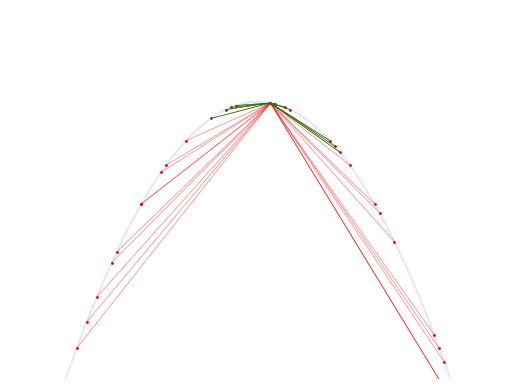

In [19]:
# Plot the samples and original function
fig = plt.figure()
ax = fig.add_subplot(111)
#plt.scatter(x, y, c='r', s=1)
ax.plot(x,z,color='b',alpha=0.1)
point_height = f(sampled_points)
ax.scatter(sampled_points,point_height, c='r', s=1)
# selective anchor points 
anchor_0 = np.argmin(sampled_points**2)
anchor_1 = np.argmin((sampled_points-1)**2)
anchor_n1 = np.argmin((sampled_points+1)**2)
anchors = [anchor_0, anchor_1, anchor_n1]
linked_points = {anchor:knn_graph[anchor].nonzero()[1] for anchor in anchors}
trimmed_points = {anchor:max_curv_indicies[anchor] for anchor in anchors}
for anchor, points in linked_points.items():
    for point in points:
        ax.plot([sampled_points[anchor], sampled_points[point]], [point_height[anchor], point_height[point]], color='r', alpha=0.5, linewidth=0.5)
for anchor, points in trimmed_points.items():
    for point in points:
        ax.plot([sampled_points[anchor], sampled_points[point]], [point_height[anchor], point_height[point]], color='g', alpha=1, linewidth=0.5)

plt.axis('off')
plt.xlim(-0.05,0.05)
plt.ylim(1.4985,1.5005)
plt.show()


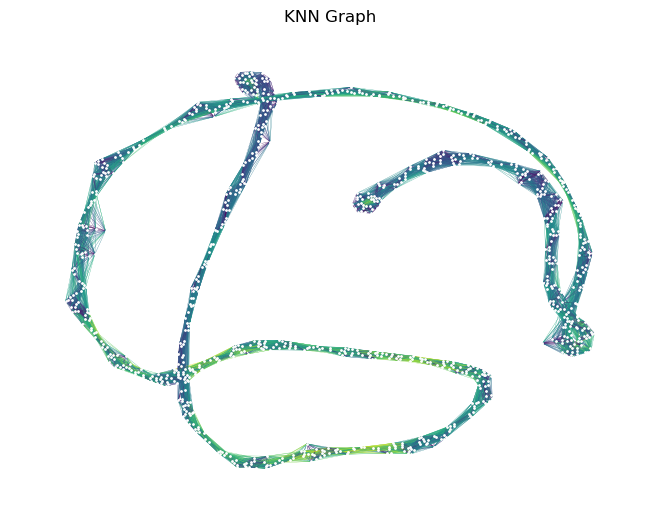

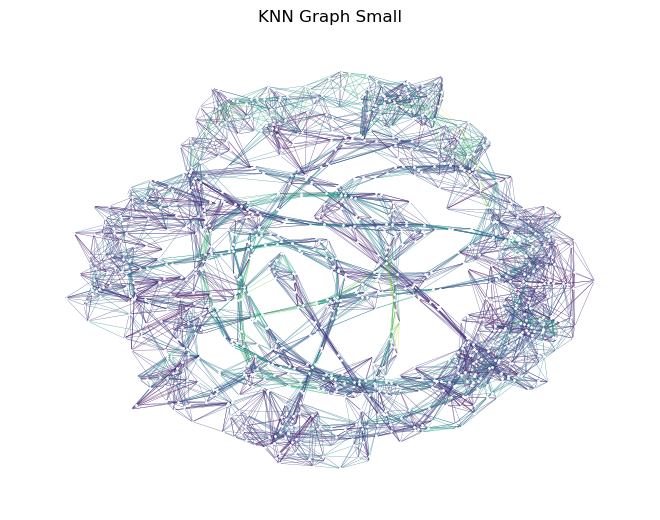

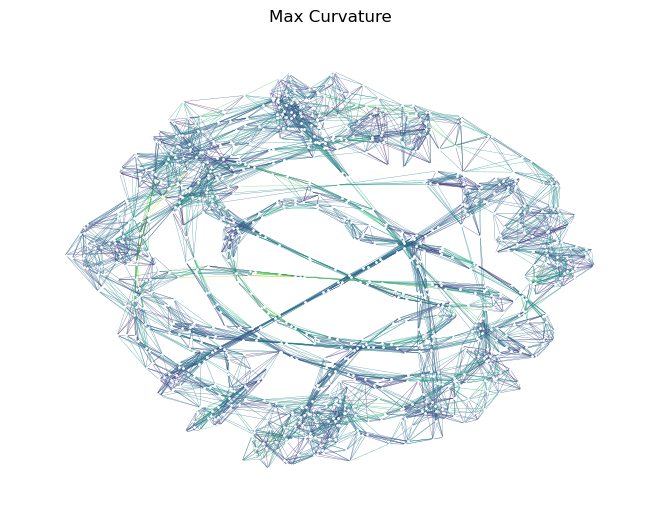

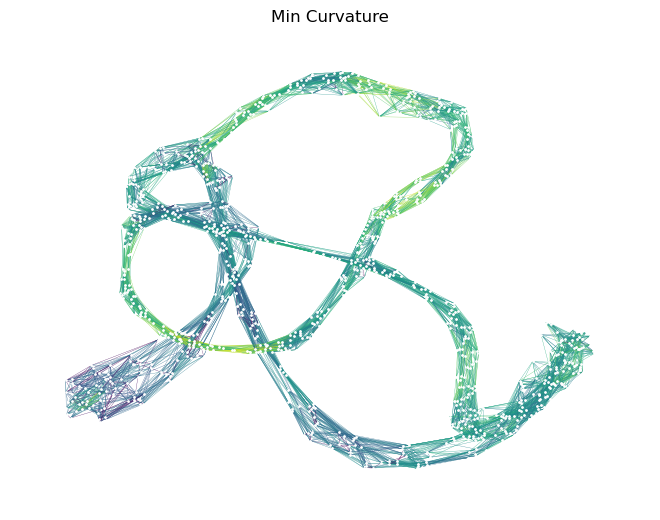

In [7]:
import networkx as nx
def drawGraph(adj):
    graph = nx.from_numpy_array(adj)
    edge_value = nx.get_edge_attributes(graph,'weight')
    edge_value = edge_value.values()
    nx.draw(graph,node_color='white',node_size=1,width=0.2,edge_color=edge_value,edge_cmap=plt.cm.viridis)
    return
for graph,title in zip([knn_graph,small_knn_graph,max_curv_graph,min_curv_graph],["KNN Graph","KNN Graph Small","Max Curvature","Min Curvature"]):
    drawGraph(graph)
    plt.title(title)
    plt.show()

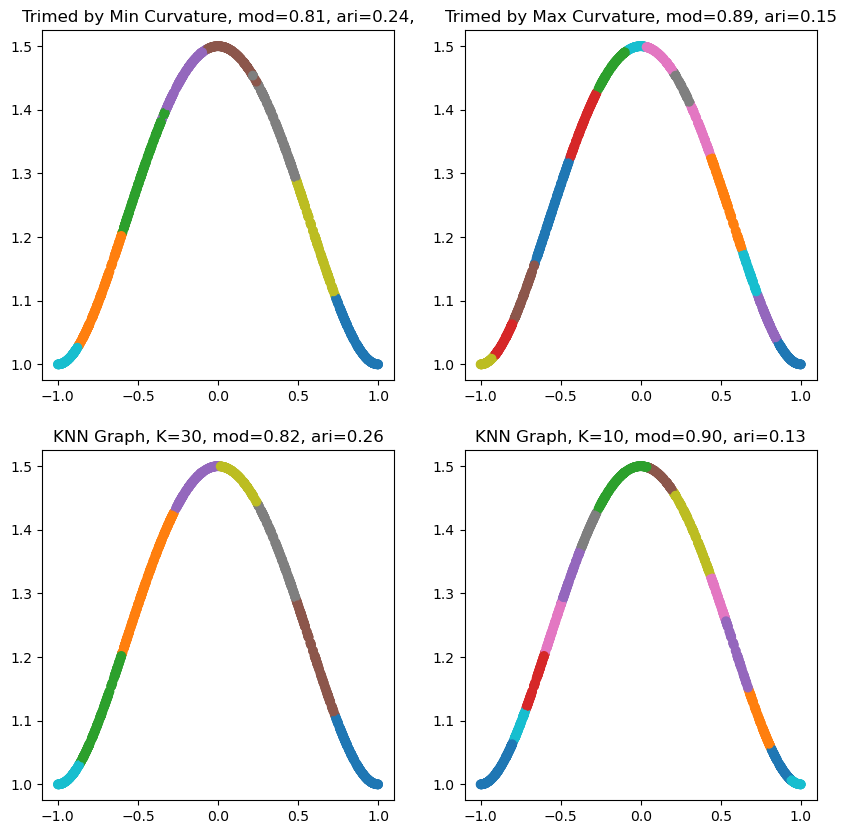

In [8]:
true_labels = [np.floor(x)+4 for x in sampled_points]
louvain = Louvain(resolution=0.5)
labels_min = louvain.fit_predict(min_curv_graph)
labels_max = louvain.fit_predict(max_curv_graph)
labels_knn = louvain.fit_predict(knn_graph)
labels_knn_small = louvain.fit_predict(small_knn_graph)
fig,ax = plt.subplots(2,2,figsize=(10,10))
ax[0,0].scatter(sampled_points,point_height,c=labels_min,cmap='tab10')
ax[0,0].set_title('Trimed by Min Curvature, mod={:.2f}, ari={:.2f},'.format(get_modularity(min_curv_graph,labels_min),adjusted_rand_score(true_labels,labels_min)))
ax[0,1].scatter(sampled_points,point_height,c=labels_max,cmap='tab10')
ax[0,1].set_title('Trimed by Max Curvature, mod={:.2f}, ari={:.2f}'.format(get_modularity(max_curv_graph,labels_max),adjusted_rand_score(true_labels,labels_max)))
ax[1,0].scatter(sampled_points,point_height,c=labels_knn,cmap='tab10')
ax[1,0].set_title('KNN Graph, K=30, mod={:.2f}, ari={:.2f}'.format(get_modularity(knn_graph,labels_knn),adjusted_rand_score(true_labels,labels_knn)))
ax[1,1].scatter(sampled_points,point_height,c=labels_knn_small,cmap='tab10')
ax[1,1].set_title('KNN Graph, K=10, mod={:.2f}, ari={:.2f}'.format(get_modularity(small_knn_graph,labels_knn_small),adjusted_rand_score(true_labels,labels_knn_small)))
plt.show()

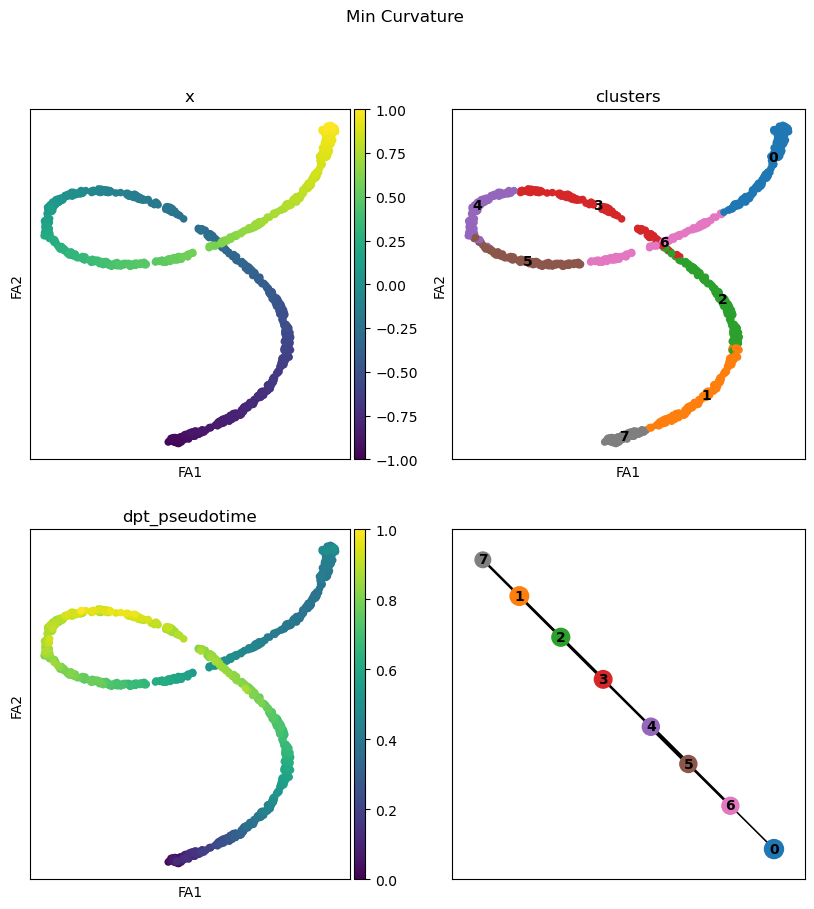

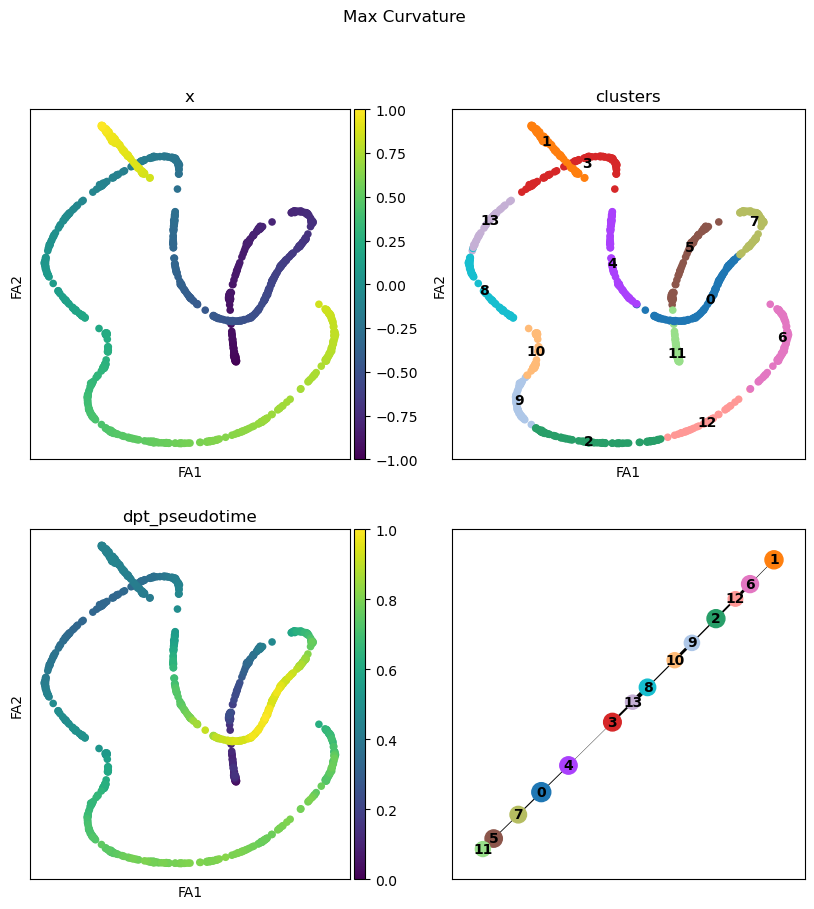

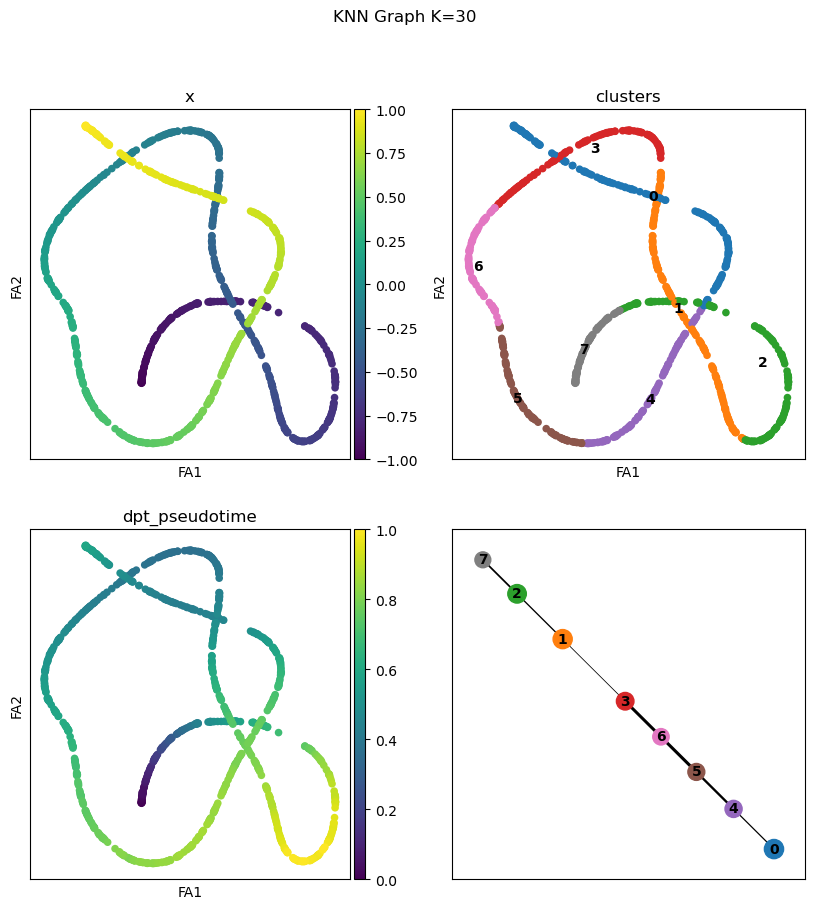

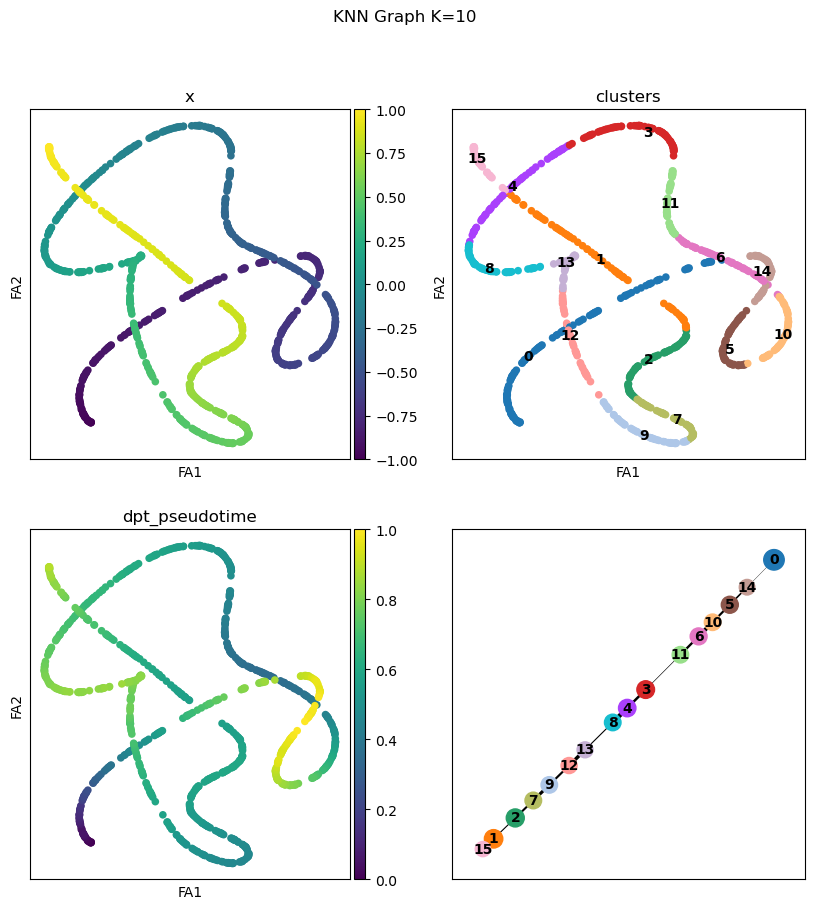

In [9]:
def plotPseudoTime(graph,pts,title,label):
    expression = ((pts + 2)*10).astype(int)
    label = pd.Categorical(label)
    point_ad = ad.AnnData(X=expression,obs={"x":pts[:,0],"clusters":label})
    point_ad.uns['neighbors'] = {"connectivities_key":"connectivities",
                                 "distances_key":"distances"}
    point_ad.obsp['connectivities'] = umap(
                *_get_indices_distances_from_sparse_matrix(graph,20),
                n_obs=1000,
                n_neighbors=20,
            )
    point_ad.obsp['distances'] = graph
    sc.tl.draw_graph(point_ad)
    root = np.argmin(pts[:,0])
    point_ad.uns['iroot'] = root
    sc.tl.diffmap(point_ad)
    sc.tl.dpt(point_ad)
    fig,axs = plt.subplots(2,2,figsize=(10,10))
    sc.pl.draw_graph(point_ad,color=["x"],legend_loc="on data",ax=axs[0,0],show=False)
    sc.pl.draw_graph(point_ad,color=["clusters"],legend_loc="on data",ax=axs[0,1],show=False)
    sc.pl.draw_graph(point_ad,color=["dpt_pseudotime"],legend_loc="on data",ax=axs[1,0],show=False)
    sc.tl.paga(point_ad,groups='clusters')
    sc.pl.paga(point_ad,ax=axs[1,1],show=False)
    fig.suptitle(title)
    return fig

for graph, title,label in [(min_curv_graph,'Min Curvature',labels_min),(max_curv_graph,'Max Curvature',labels_max),(knn_graph,'KNN Graph K=30',labels_knn),(small_knn_graph,'KNN Graph K=10',labels_knn_small)]:
    plotPseudoTime(graph,points_data,title,label)